# Библиотеки/Модули

In [145]:
import cv2
import cvlib as cv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import pygetwindow
from datetime import datetime
# import pyautogui
datalist = []
# dataframe = pd.DataFrame(columns=['date', 'typeAttendance', 'count_students', 'female_count', 'male_count'])

## Ячейка подсчёта студентов

In [25]:
def count_students(data):
    for folder in data:
        flagType = folder == "data/online/"
        counter = 0
        for date in os.listdir(folder):
            for image in os.listdir(folder + date + "/"):
                image = cv2.imread(folder + date + "/" + image)
                _, label, _ = cv.detect_common_objects(image, model="yolov3")
                counter+=label.count('person')
            datalist.append([date,flagType,counter,0,0])

## Ячейка подсчёта в зависимости от пола

In [139]:
FACE_PROTO = "weights/opencv_face_detector.pbtxt"
FACE_MODEL = "weights/opencv_face_detector_uint8.pb"
GENDER_PROTO = "weights/gender_deploy.prototxt"
GENDER_MODEL = "weights/gender_net.caffemodel"

FACE_NET = cv2.dnn.readNet(FACE_MODEL, FACE_PROTO)

GENDER_NET = cv2.dnn.readNet(GENDER_MODEL, GENDER_PROTO)

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
GENDER_LIST = ["Male", "Female"]

box_padding = 20
def get_face_box (net, frame, conf_threshold = 0.5):
  frame_copy = frame.copy()
  frame_height = frame_copy.shape[0]
  frame_width = frame_copy.shape[1]
  blob = cv2.dnn.blobFromImage(frame_copy, 1.0, (300, 300), [104, 117, 123], True, False)

  net.setInput(blob)
  detections = net.forward()
  boxes = []

  for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if confidence > conf_threshold:
      x1 = int(detections[0, 0, i, 3] * frame_width)
      y1 = int(detections[0, 0, i, 4] * frame_height)
      x2 = int(detections[0, 0, i, 5] * frame_width)
      y2 = int(detections[0, 0, i, 6] * frame_height)
      boxes.append([x1, y1, x2, y2])
      cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), int(round(frame_height / 150)), 8)

  return frame_copy, boxes
def gender_detector (data):
  for folder in data:
    flagType = "online" in folder
    fem_count = 0
    male_count = 0
    for date in os.listdir(folder):
      for image in os.listdir(folder + date + "/"):
        image = cv2.imread(folder + date + "/" + image)
        resized_image = cv2.resize(image, (640, 480))
        frame = resized_image.copy()
        _, boxes = get_face_box(FACE_NET, frame)
        for box in boxes:
          face = frame[max(0, box[1] - box_padding):min(box[3] + box_padding, frame.shape[0] - 1), \
            max(0, box[0] - box_padding):min(box[2] + box_padding, frame.shape[1] - 1)]
          blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB = False)
          GENDER_NET.setInput(blob)
          gender_predictions = GENDER_NET.forward()
          gender = GENDER_LIST[gender_predictions[0].argmax()]
          if gender == "Male":
            male_count+=1
          else: fem_count+=1
      if dataframe[(dataframe['date'] == datetime.strptime(date, '%d-%m-%Y'))].shape[0]!=0:
        dataframe['male_count'] = np.where(dataframe['date'] == datetime.strptime(date, '%d-%m-%Y'), male_count, dataframe['male_count'])
        dataframe['female_count'] = np.where(dataframe['date'] == datetime.strptime(date, '%d-%m-%Y'), fem_count, dataframe['female_count'])
      else: datalist.append([date, flagType,fem_count + male_count, fem_count, male_count])

  

## Графическая часть

In [149]:
def prepare_dataset():
    dataframe = pd.DataFrame(datalist, columns=['date', 'typeAttendance', 'count_students', 'female_count', 'male_count'])
    # dataframe.set_index('date')
    dataframe = dataframe.astype({"count_students": int, "female_count":int, "male_count":int})
    if "datetime" not in dataframe.dtypes:
        dataframe['date'] = pd.to_datetime(dataframe['date'], format='%d-%m-%Y')
    dataframe['count_students'] = np.where(dataframe['count_students'] < dataframe['female_count'] + dataframe['male_count'], dataframe['female_count'] + dataframe['male_count'], dataframe['count_students'])
    return dataframe.drop_duplicates(subset = ['date'])
def get_attendance_stat_avg(start_date="", end_date=""):
    dataframe = prepare_dataset()
    if (start_date != "" and end_date != ""):
        mask = (dataframe['date'] > start_date) & (dataframe['date'] <= end_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость за предложенный период: ', df['count_students'].mean())
            df.plot(x = 'date', y ='count_students')
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (start_date != ""):
        mask = (dataframe['date'] > start_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость за предложенный период: ', df['count_students'].mean())
            df.plot(x = 'date', y ='count_students')
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (end_date != ""):
        mask = (dataframe['date'] < end_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость за предложенный период: ', df['count_students'].mean())
            df.plot(x = 'date', y ='count_students')
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    else:
        print('Средняя посещаемость за всё время: ', dataframe['count_students'].mean())
        dataframe.plot(x = 'date', y ='count_students')

def get_attendance_by_gender(start_date = "", end_date = ""):
    dataframe = prepare_dataset()
    print(dataframe.head(10))
    if (start_date != "" and end_date != ""):
        mask = (dataframe['date'] > start_date) & (dataframe['date'] <= end_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость мужчин за предложенный период: ', df['male_count'].mean())
            print('Средняя посещаемость девушек за предложенный период: ', df['female_count'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df.plot(x='date', y='female_count',ax=ax[0])
            df.plot(x='date', y='male_count',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (start_date != ""):
        mask = (dataframe['date'] > start_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость мужчин за предложенный период: ', df['male_count'].mean())
            print('Средняя посещаемость девушек за предложенный период: ', df['female_count'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df.plot(x='date', y='female_count',ax=ax[0])
            df.plot(x='date', y='male_count',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (end_date != ""):
        mask = (dataframe['date'] < end_date)
        try:
            df = dataframe.loc[mask]
            print('Средняя посещаемость мужчин за предложенный период: ', df['male_count'].mean())
            print('Средняя посещаемость девушек за предложенный период: ', df['female_count'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df.plot(x='date', y='female_count',ax=ax[0])
            df.plot(x='date', y='male_count',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    else:
        print('Средняя посещаемость мужчин за предложенный период: ', dataframe['male_count'].mean())
        print('Средняя посещаемость девушек за предложенный период: ', dataframe['female_count'].mean())
        fig, ax = plt.subplots(nrows= 1, ncols=2)
        dataframe.plot(x='date', y='female_count',ax=ax[0])
        dataframe.plot(x='date', y='male_count',ax=ax[1])
def get_attendance_by_type(start_date = "", end_date = ""):
    dataframe = prepare_dataset()
    if (start_date != "" and end_date != ""):
        mask_online = (dataframe['date'] > start_date) & (dataframe['date'] <= end_date) & (dataframe['typeAttendance'] == True)
        mask_offline = (dataframe['date'] > start_date) & (dataframe['date'] <= end_date) & (dataframe['typeAttendance'] == False)
        try:
            df_online = dataframe.loc[mask_online]
            df_offline = dataframe.loc[mask_offline]
            print('Средняя посещаемость онлайн за предложенный период: ', df_online['count_students'].mean())
            print('Средняя посещаемость онлайн за предложенный период: ', df_offline['count_students'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df_online.plot(x='date', y='count_students',ax=ax[0])
            dataframe.plot(x='date', y='count_students',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (start_date != ""):
        mask_online = (dataframe['date'] > start_date) & (dataframe['typeAttendance'] == True)
        mask_offline = (dataframe['date'] > start_date)& (dataframe['typeAttendance'] == False)
        try:
            df_online = dataframe.loc[mask_online]
            df_offline = dataframe.loc[mask_offline]
            print('Средняя посещаемость онлайн за предложенный период: ', df_online['count_students'].mean())
            print('Средняя посещаемость онлайн за предложенный период: ', df_offline['count_students'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df_online.plot(x='date', y='count_students',ax=ax[0])
            dataframe.plot(x='date', y='count_students',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    if (end_date != ""):
        mask_online = (dataframe['date'] <= end_date) & (dataframe['typeAttendance'] == True)
        mask_offline = (dataframe['date'] <= end_date) & (dataframe['typeAttendance'] == False)
        try:
            df_online = dataframe.loc[mask_online]
            df_offline = dataframe.loc[mask_offline]
            print('Средняя посещаемость онлайн за предложенный период: ', df_online['count_students'].mean())
            print('Средняя посещаемость онлайн за предложенный период: ', df_offline['count_students'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df_online.plot(x='date', y='count_students',ax=ax[0])
            dataframe.plot(x='date', y='count_students',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")
    else:
        print(dataframe.head())
        mask_online = dataframe['typeAttendance'] == True
        mask_offline = dataframe['typeAttendance'] == False
        try:
            df_online = dataframe.loc[mask_online]
            df_offline = dataframe.loc[mask_offline]
            print('Средняя посещаемость онлайн за предложенный период: ', df_online['count_students'].mean())
            print('Средняя посещаемость онлайн за предложенный период: ', df_offline['count_students'].mean())
            fig, ax = plt.subplots(nrows= 1, ncols=2)
            df_online.plot(x='date', y='count_students',ax=ax[0])
            df_offline.plot(x='date', y='count_students',ax=ax[1])
        except KeyError:
            print("Указан неверный период или данных нет за данный период")

# Взаимодействие

### Переменные для работы с проектом

In [9]:
online_dir = "data/online/"
face_to_face_dir = "data/face-to-face/"
Web = True
counter_screenshots = 0
# Для случаев, когда используется Google Meet
Conf_id = "vzb-edwm-iau"
today_date = datetime.today().strftime('%d-%m-%Y')
# Даты для выбора анализируемого периода
start_date = ""
end_date = ""

### Сделать скриншот Zoom/Google Meet

In [23]:
window_titles = pygetwindow.getAllTitles()
if not os.path.exists(online_dir + today_date):
    os.makedirs(online_dir + today_date)
if Web:
    path = online_dir + today_date + f"/{str(counter_screenshots)}.png"
    matching_window = [s for s in window_titles if any(xs in s for xs in [Conf_id])]
    window = pygetwindow.getWindowsWithTitle(matching_window[0])[0]
    left, top = window.topleft
    right, bottom = window.bottomright
    pyautogui.screenshot(path)
    image = Image.open(path)
    image = image.crop((left, top, right, bottom))
    image.save(path)
    counter_screenshots+=1
else:
    path = online_dir + today_date + f"/{str(counter_screenshots)}.png"
    matching_window = [s for s in window_titles if any(xs in s for xs in ["Zoom"])]
    window = pygetwindow.getWindowsWithTitle(matching_window[0])[0]
    left, top = window.topleft
    right, bottom = window.bottomright
    pyautogui.screenshot(path)
    image = Image.open(path)
    image = image.crop((left, top, right, bottom))
    image.save(path)
    counter_screenshots+=1

### Анализ посещаемости студентов в общем (онлайн и очно)

Средняя посещаемость за всё время:  13.333333333333334


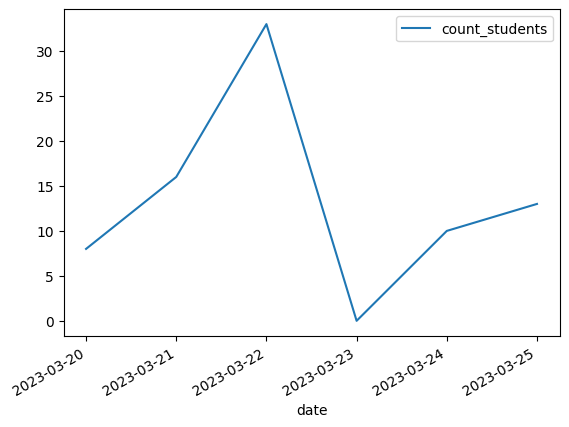

In [141]:
count_students([online_dir, face_to_face_dir])
get_attendance_stat_avg()

### Анализ посещаемости студентов в разрезе формата занятий

        date  typeAttendance  count_students  female_count  male_count
0 2023-03-23            True               0             0           0
1 2023-03-24            True              10             0           0
2 2023-03-25            True              13             0           0
3 2023-03-20           False               8             0           0
4 2023-03-21           False              16             0           0
Средняя посещаемость онлайн за предложенный период:  7.666666666666667
Средняя посещаемость онлайн за предложенный период:  19.0


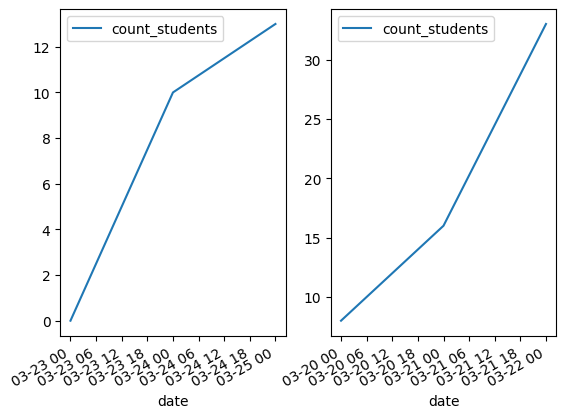

In [108]:
get_attendance_by_type()

### Анализ посещаемости студентов в разрезе пола 

        date  typeAttendance  count_students  female_count  male_count
0 2023-03-23            True               0             0           0
1 2023-03-24            True               5             4           1
2 2023-03-25            True               6             4           2
3 2023-03-20           False               4             2           2
4 2023-03-21           False               9             5           4
5 2023-03-22           False              10             5           5
Средняя посещаемость мужчин за предложенный период:  2.3333333333333335
Средняя посещаемость девушек за предложенный период:  3.3333333333333335


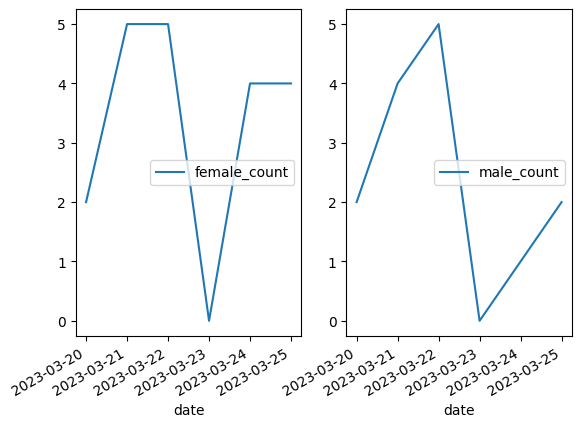

In [150]:
gender_detector([online_dir, face_to_face_dir])
get_attendance_by_gender()
